In [49]:
from mccn.client import MCCN

In [50]:
engine = MCCN("/Users/a1234648/mccn-engine/generated_new/collection.json", "collection", 100, raster_dtype="uint8")

In [51]:
s = engine.load()

In [9]:
s

<xarray.Dataset> Size: 1MB
Dimensions:              (y: 100, x: 100, time: 2)
Coordinates:
  * y                    (y) float64 800B -28.08 -28.17 -28.27 ... -37.33 -37.42
  * x                    (x) float64 800B 141.0 141.1 141.2 ... 153.5 153.6
  * time                 (time) datetime64[ns] 16B 2009-12-30T13:55:00 2022-0...
    spatial_ref          int32 4B 4326
Data variables: (12/17)
    soc_0_5_mean         (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    soc_5_15_mean        (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    soc_15_30_mean       (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    soc_0_10_mean        (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    soc_10_30_mean       (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    soc_0_30_mean        (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    ...                   ...
    ph_100_200_mean      (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    ph_0_10_mean         (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    ph_10_30_mean        (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    ph_0_30_mean         (time, y, x) float32 80kB nan nan nan ... 0.0 0.0 0.0
    rainfall_mm          (time, y, x) float32 80kB 0.0 0.0 0.0 ... nan nan nan
    temperature_celsius  (time, y, x) float32 80kB 0.0 0.0 0.0 ... nan nan nan

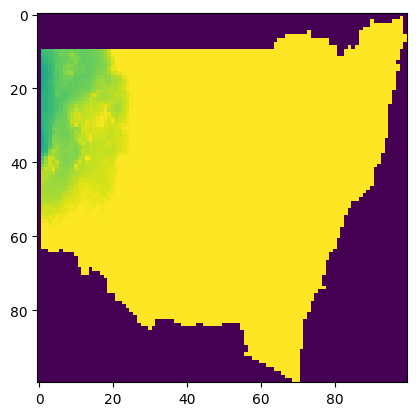

In [25]:
import matplotlib.pyplot as plt
plt.imshow(s.rainfall_mm.values[0, :, :])
plt.show()


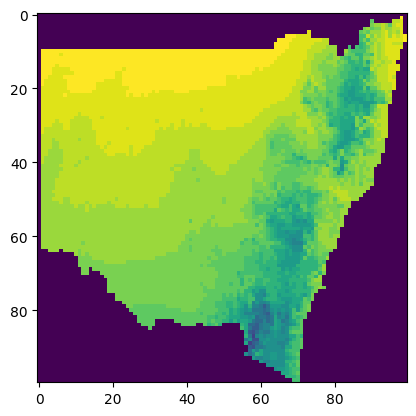

In [52]:
import matplotlib.pyplot as plt
plt.imshow(s.temperature_celsius.values[0, :, :])
plt.show()


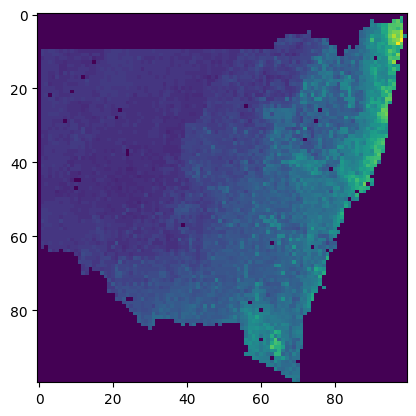

In [54]:
import matplotlib.pyplot as plt
plt.imshow(s.soc_0_30_mean.values[1, :, :])
plt.show()

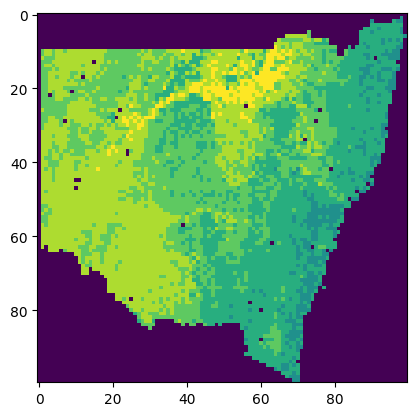

In [55]:
import matplotlib.pyplot as plt
plt.imshow(s.ph_0_30_mean.values[1, :, :])
plt.show()

In [56]:
import numpy as np

def environmental_distance(point_values, layer_values):
    """Calculate environmental distance in 5D space"""
    differences = np.power(np.abs(point_values - layer_values), 5)
    return np.power(np.prod(differences, axis=-1), 1/5)


In [57]:
s.temperature_celsius.values[0]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 20.,  0.],
       [ 0.,  0.,  0., ..., 18., 19.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
      shape=(100, 100), dtype=float32)

In [59]:
selected_layers = [
    s.soc_0_30_mean.values[1], 
    s.ph_0_30_mean.values[1],
    s.rainfall_mm.values[0],
    s.temperature_celsius.values[0]
]

In [60]:
layer_values = np.stack(selected_layers, axis=-1)

layer_values

array([[[  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,   0.],
        [ 36.,   4., 255.,  20.],
        [  0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        ...,
        [ 43.,   4., 255.,  18.],
        [ 33.,   4., 255.,  19.],
        [  0.,   0.,   0.,   0.]],

       ...,

       [[  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.],
        .

In [61]:
# Stack layers into a single array
layer_values = np.stack(selected_layers, axis=-1)

# Create valid mask (where we have data for all layers)
# Exclude both NaN and zero values for SOC and pH (indices 0 and 1)
valid_mask = (
    ~np.any(np.isnan(layer_values), axis=-1) &  # No NaN values
    (layer_values[..., 0] > 0) &                # SOC > 0
    (layer_values[..., 1] > 0)                  # pH > 0
)

valid_indices = np.where(valid_mask)
valid_positions_all = list(zip(valid_indices[0], valid_indices[1]))



In [63]:
n_valid = len(valid_positions_all)
print(f"Found {n_valid} valid positions in the data")

Found 6344 valid positions in the data


The optimal new point is the one that is furthest from all existing points in environmental space
The environmental distance calculation works like this:
* For a point with values [SOC=1.2, pH=6.5, rainfall=100, temp=20]
* Comparing to another point [SOC=1.0, pH=6.0, rainfall=90, temp=22]
* Take absolute differences: [0.2, 0.5, 10, 2]
* Raise each to power 5: [0.00032, 0.03125, 100000, 32]
* Multiply them together
* Take fifth root of result
This gives us a single number representing how different two points are across all environmental variables.

In [66]:
import random
if n_valid == 0:
    print("Error: No valid positions found. Cvheck your data for NaN values.")
else:
    # Use all valid positions if less than 10, otherwise sample 10
    n_samples = min(n_valid, 10)
    valid_positions = random.sample(valid_positions_all, n_samples)
    
    print(f"\nUsing {n_samples} sampling positions")

    # Calculate distance layers for each point
    distance_layers = []
    for pos in valid_positions:
        point_values = layer_values[pos[0], pos[1]]
        distances = environmental_distance(point_values, layer_values)
        distance_layers.append(distances)

    # Convert to numpy array for easier operations
    distance_layers = np.stack(distance_layers, axis=0)

    # Find minimum distance to any point for each pixel
    min_distances = np.nanmin(distance_layers, axis=0)

    # Find the point with maximum minimum distance among valid positions
    min_distances[~valid_mask] = np.nan  # Ensure we don't select invalid positions
    optimal_position = np.unravel_index(np.nanargmax(min_distances), min_distances.shape)
    max_min_distance = min_distances[optimal_position]

    # Print results
    print("\nCurrent sampling points:")
    for i, pos in enumerate(valid_positions, 1):
        print(f"Point {i}: Row: {pos[0]}, Col: {pos[1]}")
        values = layer_values[pos[0], pos[1]]
        print(f"  SOC: {values[0]:.3f}, pH: {values[1]:.3f}, "
              f"Rainfall: {values[2]:.3f}, Temp: {values[3]:.3f}")

    print(f"\nOptimal new sampling location:")
    print(f"Row: {optimal_position[0]}, Col: {optimal_position[1]}")
    opt_values = layer_values[optimal_position[0], optimal_position[1]]
    print(f"Environmental values at optimal point:")
    print(f"SOC: {opt_values[0]:.3f}, pH: {opt_values[1]:.3f}, "
          f"Rainfall: {opt_values[2]:.3f}, Temp: {opt_values[3]:.3f}")
    print(f"Environmental distance score: {max_min_distance:.5f}")


Using 10 sampling positions

Current sampling points:
Point 1: Row: 65, Col: 65
  SOC: 18.000, pH: 5.000, Rainfall: 255.000, Temp: 12.000
Point 2: Row: 15, Col: 51
  SOC: 9.000, pH: 7.000, Rainfall: 255.000, Temp: 20.000
Point 3: Row: 54, Col: 62
  SOC: 16.000, pH: 5.000, Rainfall: 255.000, Temp: 13.000
Point 4: Row: 28, Col: 45
  SOC: 11.000, pH: 6.000, Rainfall: 255.000, Temp: 19.000
Point 5: Row: 36, Col: 79
  SOC: 17.000, pH: 5.000, Rainfall: 255.000, Temp: 14.000
Point 6: Row: 83, Col: 44
  SOC: 15.000, pH: 6.000, Rainfall: 255.000, Temp: 15.000
Point 7: Row: 31, Col: 41
  SOC: 11.000, pH: 5.000, Rainfall: 255.000, Temp: 18.000
Point 8: Row: 10, Col: 21
  SOC: 10.000, pH: 6.000, Rainfall: 255.000, Temp: 20.000
Point 9: Row: 48, Col: 42
  SOC: 10.000, pH: 6.000, Rainfall: 255.000, Temp: 17.000
Point 10: Row: 77, Col: 28
  SOC: 17.000, pH: 6.000, Rainfall: 255.000, Temp: 16.000

Optimal new sampling location:
Row: 1, Col: 98
Environmental values at optimal point:
SOC: 36.000, pH: 4

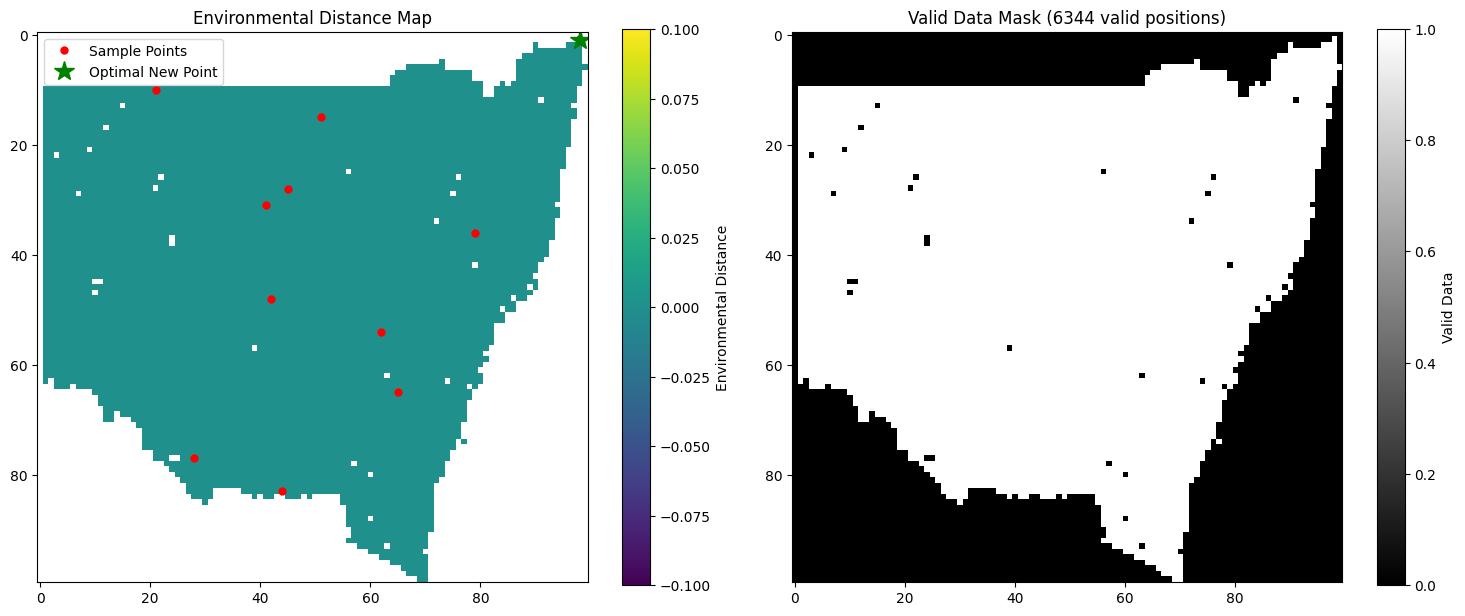


Data range in valid positions:
SOC: Min = 6.000, Max = 57.000
pH: Min = 4.000, Max = 8.000
Rainfall: Min = 150.000, Max = 255.000
Temperature: Min = 4.000, Max = 20.000


In [68]:
# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot distance map
masked_distances = np.ma.masked_array(min_distances, ~valid_mask)
im1 = ax1.imshow(masked_distances, cmap='viridis')
plt.colorbar(im1, ax=ax1, label='Environmental Distance')
ax1.plot([p[1] for p in valid_positions], [p[0] for p in valid_positions], 'r.', 
            markersize=10, label='Sample Points')
ax1.plot(optimal_position[1], optimal_position[0], 'g*', 
            markersize=15, label='Optimal New Point')
ax1.legend()
ax1.set_title('Environmental Distance Map')

# Plot validity mask (white where valid data, black where invalid)
im2 = ax2.imshow(valid_mask, cmap='gray')
plt.colorbar(im2, ax=ax2, label='Valid Data')
ax2.set_title(f'Valid Data Mask ({n_valid} valid positions)')

plt.tight_layout()
plt.show()

# Additional diagnostic information
print("\nData range in valid positions:")
for i, layer_name in enumerate(['SOC', 'pH', 'Rainfall', 'Temperature']):
    valid_data = layer_values[valid_mask, i]
    print(f"{layer_name}: Min = {np.min(valid_data):.3f}, Max = {np.max(valid_data):.3f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_environmental_distance_example(layer_values, valid_positions, optimal_position, valid_mask, src):
    # Create figure with 3 subplots
    fig = plt.figure(figsize=(20, 10))
    gs = plt.GridSpec(2, 3)
    ax1 = fig.add_subplot(gs[:, 0])  # Distance map
    ax2 = fig.add_subplot(gs[0, 1])  # Spider plot for sample points
    ax3 = fig.add_subplot(gs[0, 2])  # Spider plot for optimal point
    ax4 = fig.add_subplot(gs[1, 1:])  # Distance calculation explanation
    
    # 1. Plot distance map with geographic coordinates
    masked_distances = np.ma.masked_array(min_distances, ~valid_mask)
    im1 = ax1.imshow(masked_distances, cmap='viridis', origin='upper')
    plt.colorbar(im1, ax=ax1, label='Environmental Distance')
    
    # Convert array indices to geographic coordinates
    sample_coords = []
    for pos in valid_positions:
        lon, lat = s.xy(pos[0], pos[1])
        sample_coords.append((lon, lat))
        ax1.plot(pos[1], pos[0], 'r.', markersize=10)
        ax1.annotate(f'({lat:.2f}°, {lon:.2f}°)', 
                    (pos[1], pos[0]), 
                    xytext=(5, 5), 
                    textcoords='offset points', 
                    color='red', 
                    fontsize=8)
    
    # Plot optimal point
    opt_lon, opt_lat = s.xy(optimal_position[0], optimal_position[1])
    ax1.plot(optimal_position[1], optimal_position[0], 'g*', markersize=15)
    ax1.annotate(f'Optimal:\n({opt_lat:.2f}°, {opt_lon:.2f}°)', 
                (optimal_position[1], optimal_position[0]), 
                xytext=(5, 5), 
                textcoords='offset points', 
                color='green', 
                fontsize=8)
    
    ax1.set_title('Environmental Distance Map\nwith Geographic Coordinates')
    
    # 2. Create spider plots to visualize environmental variables
    categories = ['SOC', 'pH', 'Rainfall', 'Temp']
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
    
    # Function to create spider plot
    def make_spider_plot(ax, values, title):
        values = np.concatenate((values, [values[0]]))  # complete the loop
        angles_plot = np.concatenate((angles, [angles[0]]))  # complete the loop
        
        ax.plot(angles_plot, values, 'o-')
        ax.fill(angles_plot, values, alpha=0.25)
        ax.set_xticks(angles)
        ax.set_xticklabels(categories)
        ax.set_title(title)
    
    # Plot for first sample point
    sample_values = layer_values[valid_positions[0][0], valid_positions[0][1]]
    make_spider_plot(ax2, sample_values, f'Environmental Values\nSample Point 1')
    
    # Plot for optimal point
    opt_values = layer_values[optimal_position[0], optimal_position[1]]
    make_spider_plot(ax3, opt_values, 'Environmental Values\nOptimal Point')
    
    # 3. Show distance calculation
    ax4.axis('off')
    calculation_text = (
        "Environmental Distance Calculation Example:\n"
        f"Sample Point 1: SOC={sample_values[0]:.2f}, pH={sample_values[1]:.2f}, "
        f"Rainfall={sample_values[2]:.2f}, Temp={sample_values[3]:.2f}\n"
        f"Optimal Point: SOC={opt_values[0]:.2f}, pH={opt_values[1]:.2f}, "
        f"Rainfall={opt_values[2]:.2f}, Temp={opt_values[3]:.2f}\n\n"
        "1. Take absolute differences:\n"
        f"   SOC: |{sample_values[0]:.2f} - {opt_values[0]:.2f}| = {abs(sample_values[0]-opt_values[0]):.2f}\n"
        f"   pH: |{sample_values[1]:.2f} - {opt_values[1]:.2f}| = {abs(sample_values[1]-opt_values[1]):.2f}\n"
        f"   Rainfall: |{sample_values[2]:.2f} - {opt_values[2]:.2f}| = {abs(sample_values[2]-opt_values[2]):.2f}\n"
        f"   Temp: |{sample_values[3]:.2f} - {opt_values[3]:.2f}| = {abs(sample_values[3]-opt_values[3]):.2f}\n"
        "2. Raise each to power 5\n"
        "3. Multiply results\n"
        "4. Take fifth root of product"
    )
    ax4.text(0, 0.5, calculation_text, va='center', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_environmental_distance_example(layer_values, valid_positions, optimal_position, valid_mask, s)

# Print full details for all points
print("\nDetailed Environmental Values:")
print("\nSample Points:")
for i, pos in enumerate(valid_positions):
    lon, lat = s.xy(pos[0], pos[1])
    values = layer_values[pos[0], pos[1]]
    print(f"\nPoint {i+1} ({lat:.2f}°, {lon:.2f}°):")
    print(f"  SOC: {values[0]:.3f}")
    print(f"  pH: {values[1]:.3f}")
    print(f"  Rainfall: {values[2]:.3f}")
    print(f"  Temperature: {values[3]:.3f}")

print("\nOptimal Point:")
opt_lon, opt_lat = s.xy(optimal_position[0], optimal_position[1])
opt_values = layer_values[optimal_position[0], optimal_position[1]]
print(f"Location: ({opt_lat:.2f}°, {opt_lon:.2f}°)")
print(f"  SOC: {opt_values[0]:.3f}")
print(f"  pH: {opt_values[1]:.3f}")
print(f"  Rainfall: {opt_values[2]:.3f}")
print(f"  Temperature: {opt_values[3]:.3f}")

NameError: name 'src' is not defined